In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
## change font for plots
import matplotlib
from matplotlib import rc
matplotlib.rcParams['pdf.fonttype'] = 42 # to import text in illustrator
matplotlib.rcParams['ps.fonttype'] = 42
rc('font',**{'family':'serif','serif':['Arial']})

SMALL_SIZE = 8
MEDIUM_SIZE = 10

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [3]:
## define cm2inch for plot size
def cm2inch(*tupl): # cm to inch for figure size
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [4]:
## write mupltiple panda dataframes to excel
# from https://stackoverflow.com/questions/32957441/putting-many-python-pandas-dataframes-to-one-excel-worksheet
def dfs_tabs(df_list, sheet_list, file_name):
    writer = pd.ExcelWriter(file_name,engine='xlsxwriter')   
    for dataframe, sheet in zip(df_list, sheet_list):
        dataframe.to_excel(writer, sheet_name=sheet, startrow=0 , startcol=0)   
    writer.save()

# Time-Depth-Conversion
Here, we use multiple wells to calculate the time-depth conversion. For highest accuracy, we use different wells for sill S1 and S2.

In [5]:
## import checkshot data from excel sheet
input_path   = '/Users/Suppl3_quantifying_connectors_heights/checkshot_data.xlsx'

toporoa      = pd.read_excel(input_path, sheet_name=0)
briseis      = pd.read_excel(input_path, sheet_name=1)
glencoe1     = pd.read_excel(input_path, sheet_name=2)
chester1_st1 = pd.read_excel(input_path, sheet_name=4)
makybe_diva1 = pd.read_excel(input_path, sheet_name=5)
hijinx1      = pd.read_excel(input_path, sheet_name=6)
lightfinger1 = pd.read_excel(input_path, sheet_name=7)
nimblefoot   = pd.read_excel(input_path, sheet_name=8)

In [6]:
## merge wells for specific areas
# S1
MD_S1  = -np.concatenate((chester1_st1['MD'].values, makybe_diva1['MD'].values, 
                        hijinx1['MD'].values, lightfinger1['MD'].values, nimblefoot['MD'].values)) # measured depth [m]
TWT_S1 = np.concatenate((chester1_st1['TWT'].values, makybe_diva1['TWT'].values, 
                        hijinx1['TWT'].values, lightfinger1['TWT'].values, nimblefoot['TWT'].values)) # two-way-travel time [ms]

# S2
MD_S2  = -np.concatenate((toporoa['MD'].values, briseis['MD'].values, glencoe1['MD'].values)) # measured depth [m]
TWT_S2 = np.concatenate((toporoa['TWT'].values, briseis['TWT'].values, glencoe1['TWT'].values)) # two-way-travel time [ms]

In [7]:
## polynomial regression
# S1
p_S1  = np.polyfit(TWT_S1, MD_S1, 2, full=True)
MD_S1_fit = np.polyval(p_S1[0], TWT_S1)

# S2
p_S2  = np.polyfit(TWT_S2, MD_S2, 2, full=True)
MD_S2_fit = np.polyval(p_S2[0], TWT_S2)

In [8]:
## sort data
# S1
TWT_S1_sort = sorted(TWT_S1)
MD_S1_fit_sort = sorted(MD_S1_fit, reverse=True)
MD_S1_sort = sorted(MD_S1, reverse=True)

# S2
TWT_S2_sort = sorted(TWT_S2)
MD_S2_fit_sort = sorted(MD_S2_fit, reverse=True)
MD_S2_sort = sorted(MD_S2, reverse=True)

In [9]:
## fit accuracy
# S1
# correlation coefficient
correlation_matrix = np.corrcoef(MD_S1_fit_sort, MD_S1_sort) # compare MD1_sort (depth in m from regression), with MD_sel_sort (depth in m from checkshots)
correlation_xy = correlation_matrix[0,1]
r_squared_S1 = correlation_xy**2

# Root Mean Square Error (RMSE)
RMSE_S1 = np.sqrt(((MD_S1 - MD_S1_fit) ** 2).mean())

# S2
# correlation coefficient
correlation_matrix = np.corrcoef(MD_S2_fit_sort, MD_S2_sort) # compare MD1_sort (depth in m from regression), with MD_sel_sort (depth in m from checkshots)
correlation_xy = correlation_matrix[0,1]
r_squared_S2 = correlation_xy**2

# Root Mean Square Error (RMSE)
RMSE_S2 = np.sqrt(((MD_S2 - MD_S2_fit) ** 2).mean())

In [10]:
## calculate time-depth conversion from 1000-5500 [m] depth

TWT      = np.linspace(1500, 8000, 1500)
depth_S1 = np.polyval(p_S1[0], TWT)
depth_S2 = np.polyval(p_S2[0], TWT)

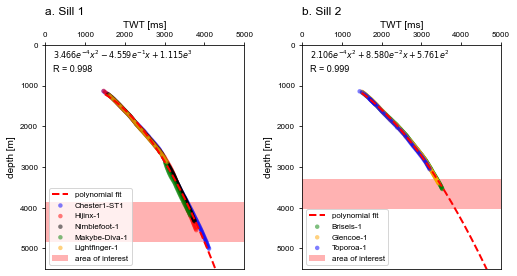

In [11]:
## plot
fig1, axs = plt.subplots(1,2, figsize=cm2inch(18.5,10))

# S1
ax=axs[0]
ax.scatter(chester1_st1['TWT'].values, chester1_st1['MD'].values, 
           facecolor='b', marker = 'o', s=20, alpha=0.5, edgecolors='none', label='Chester1-ST1')
ax.scatter(hijinx1['TWT'].values, hijinx1['MD'].values, 
           facecolor='r', marker = 'o', s=20, alpha=0.5, edgecolors='none', label='Hijinx-1')
ax.scatter(nimblefoot['TWT'].values, nimblefoot['MD'].values, 
           facecolor='k', marker = 'o', s=20, alpha=0.5, edgecolors='none', label='Nimblefoot-1')
ax.scatter(makybe_diva1['TWT'].values, makybe_diva1['MD'].values, 
           facecolor='g', marker = 'o', s=20, alpha=0.5, edgecolors='none', label='Makybe-Diva-1')
ax.scatter(lightfinger1['TWT'].values, lightfinger1['MD'].values, 
           facecolor='orange', marker = 'o', s=20, alpha=0.5, edgecolors='none', label='Lightfinger-1')

ax.plot(TWT, -depth_S1, 'r--', lw=2, label = 'polynomial fit')

ax.fill_between(np.array((0,5000)), 3865, 4838,
                color='r',linewidth=0, alpha=0.3, zorder=0, label='area of interest')


# annotation
ax.text(200, 350, '$ 3.466e^{-4}x^2 - 4.559e^{-1}x + 1.115e^3 $', fontsize=8)
ax.text(200, 650, 'R = ' + str("%.3f" % r_squared_S1), fontsize=9)

ax.set_ylim(0,5500)
ax.set_xlim(0,5000)

ax.set(ylabel='depth [m]')
ax.set(xlabel='TWT [ms]')
ax.set_title('a. Sill 1', size=12, x=0.1) # Title
ax.legend(loc='lower left')

ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
ax.xaxis.tick_top()                     # and move the X-Axis 
ax.xaxis.set_label_position("top")




# S2
ax=axs[1]

ax.scatter(briseis['TWT'].values, briseis['MD'].values, 
           facecolor='g', marker = 'o', s=20, alpha=0.5, edgecolors='none', label='Briseis-1')
ax.scatter(glencoe1['TWT'].values, glencoe1['MD'].values, 
           facecolor='orange', marker = 'o', s=20, alpha=0.5, edgecolors='none', label='Glencoe-1')
ax.scatter(toporoa['TWT'].values, toporoa['MD'].values, 
           facecolor='b', marker = 'o', s=20, alpha=0.5, edgecolors='none', label='Toporoa-1')

ax.plot(TWT, -depth_S2, 'r--', lw=2, label = 'polynomial fit')

ax.fill_between(np.array((0,5000)), 3303, 4029,
                color='r',linewidth=0, alpha=0.3, zorder=0, label='area of interest')

# annotation
ax.text(200, 350, '$ 2.106e^{-4}x^2 + 8.580e^{-2}x + 5.761e^2 $', fontsize=8)
ax.text(200, 650, 'R = ' + str("%.3f" % r_squared_S2), fontsize=9)

ax.set_ylim(0,5500)
ax.set_xlim(0,5000)

ax.set(xlabel='TWT [ms]')
ax.set(ylabel='depth [m]')
ax.set_title('b. Sill 2', size=12, x=0.1) # Title
ax.legend(loc='lower left')

ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
ax.xaxis.tick_top()                    # and move the X-Axis 
ax.xaxis.set_label_position("top")

fig1.tight_layout()

# Quantifying vertical offsets between neighbouring elements
### Create arrays with vertical offsets: 
[ID, max (or) min offset [m], element length at offset [m], max element length [m], length / max length]

Note that the element length is measured from the most inward part of the connector (0 m) towards the propagating tip (max element length).

In [12]:
import_path = '/Users/Suppl3_quantifying_connectors_heights/3_Vertical_connector_height.xlsx'
save_path = '/Users/Suppl3_quantifying_connectors_heights/'
save = 0  # save file? 0 = no, 1 = yes

In [13]:
## batch process

v_offs_max = np.zeros((1,8)) # [ID, max (or) min offset [m], error1, error2, elements length at offset [m], max element length [m], length / max length]
v_offs_min = np.zeros((1,8)) # [ID, max (or) min offset [m], error1, error2, elements length at offset [m], max element length [m], length / max length]

## import file
xl = pd.ExcelFile(import_path)
res = len(xl.sheet_names) # number of sheets

for k in range(0,res):
    
    ## import excel files
    data    = pd.read_excel(import_path, sheet_name=k)
    length  = data['length'].values # length [m]
    connect = data['connected'].values # are both elements connected? [0 = no; 1 = yes]
    fault   = data['fault'].values # pre-existing fault between element? [0 = no; 1 = yes]
    TWT_top = data['top_TWT'].values # top TWT measurement [ms]
    TWT_bot = data['bottom_TWT'].values # bottom TWT measurement [ms]
    
    ## calculate vertical offset TWT of upper and lower element (based on time-depth conversion)
    E1      = np.zeros_like(TWT_top) # empty array --> depth [m] of upper element
    E1_err1 = np.zeros_like(E1) # empty array --> estimate error of E1 --> TWT-2ms
    E1_err2 = np.zeros_like(E1) # empty array --> estimate error of E1 --> TWT+2ms
    E2      = np.zeros_like(TWT_top) # empty array --> depth [m] of lower element  
    E2_err1 = np.zeros_like(E2) # empty array --> estimate error of E2 --> TWT-2ms
    E2_err2 = np.zeros_like(E2) # empty array --> estimate error of E2 --> TWT+2ms
    v_offs  = np.zeros_like(TWT_top) # empty array to store vertical offset measurements
    
    err_TWT = 4 # [ms]; +- err_TWT to TWT measurements
    
    for j in range(0,len(TWT_top)):
        E1[j]      = np.abs(p_S1[0][0] * TWT_top[j]**2 + p_S1[0][1] * TWT_top[j] + p_S1[0][2]) # depth [m] of upper element
        E1_err1[j] = np.abs(p_S1[0][0] * (TWT_top[j]-err_TWT)**2 + p_S1[0][1] * (TWT_top[j]-err_TWT) + p_S1[0][2]) # depth [m] of upper element--> TWT-err_TWT ms to estimate error
        E1_err2[j] = np.abs(p_S1[0][0] * (TWT_top[j]+err_TWT)**2 + p_S1[0][1] * (TWT_top[j]+err_TWT) + p_S1[0][2]) # depth [m] of upper element --> TWT+err_TWT ms to estimate error
    
        E2[j]      = np.abs(p_S1[0][0] * TWT_bot[j]**2 + p_S1[0][1] * TWT_bot[j] + p_S1[0][2]) # depth [m] of lower element
        E2_err1[j] = np.abs(p_S1[0][0] * (TWT_bot[j]-err_TWT)**2 + p_S1[0][1] * (TWT_bot[j]-err_TWT) + p_S1[0][2]) # depth [m] of upper element--> TWT-err_TWT ms to estimate error
        E2_err2[j] = np.abs(p_S1[0][0] * (TWT_bot[j]+err_TWT)**2 + p_S1[0][1] * (TWT_bot[j]+err_TWT) + p_S1[0][2]) # depth [m] of upper element --> TWT+err_TWT ms to estimate error
    
    v_offs = E2-E1 # vertical offset measurements [m]
    

    ## sum up element's length
    length_tot = np.zeros(len(length))
    for i in range(0,len(length)):
        if i == 0:
            length_tot[i] = length[i]
        else:
            length_tot[i] = length_tot[i-1]+length[i]
            
    ## min & max offsets
    max_voffs = np.amax(v_offs)
    min_voffs = np.amin(v_offs)


    ## position of min & max offset
    ind1 = np.where(v_offs == max_voffs)   # ind max vertical offset
    ind2 = np.where(v_offs == min_voffs)   # ind min vertical offset
    
    
    ## estimate error
    # max offset
    max_err1 = E2_err1[ind1] - E1_err2[ind1] # lower boundary --> smaller offset
    max_err2 = E2_err2[ind1] - E1_err1[ind1] # upper boundary --> larger offset
    
    # min offset
    min_err1 = E2_err1[ind2] - E1_err2[ind2] # lower boundary --> smaller offset
    min_err2 = E2_err2[ind2] - E1_err1[ind2] # upper boundary --> larger offset
    
    
    
    ## max length at max & min offset
    max_voffs_l = length_tot[ind1]
    min_voffs_l = length_tot[ind2]

    max_voffs_rl = max_voffs_l/length_tot[-1]
    min_voffs_rl = min_voffs_l/length_tot[-1]


    
    ## create arrays with data
    
    # max vertical offset
    v_offs_max1 = np.ones((len(ind1[0]),8))
    
    for j in range(0,len(ind1[0])):
        v_offs_max1[j][0] = k
        v_offs_max1[j][1] = max_voffs                        # max vertical offset
        v_offs_max1[j][2] = np.abs(max_voffs-max_err1[j])    # estimated error; lower boundary
        v_offs_max1[j][3] = np.abs(max_voffs-max_err2[j])    # estimated error; upper boundary
        v_offs_max1[j][4] = max_voffs_l[j]                   # element length at max vertical offset
        v_offs_max1[j][5] = length_tot[-1]                   # max length of the element
        v_offs_max1[j][6] = max_voffs_l[j] / length_tot[-1]  # length / max length
        v_offs_max1[j][7] = fault[0]                         # fault; 0 = no, 1 = yes 
        
    v_offs_max = np.append(v_offs_max, v_offs_max1, axis=0)
    
    
    # min vertical offset
    v_offs_min1 = np.ones((len(ind2[0]),8))
    
    for j in range(0,len(ind2[0])):
        v_offs_min1[j][0] = k
        v_offs_min1[j][1] = min_voffs                        # min vertical offset
        v_offs_min1[j][2] = np.abs(min_voffs-min_err1[j])    # estimated error; lower boundary
        v_offs_min1[j][3] = np.abs(min_voffs-min_err2[j])    # estimated error; upper boundary
        v_offs_min1[j][4] = min_voffs_l[j]                   # segment length at min vertical offset
        v_offs_min1[j][5] = length_tot[-1]                   # total length of the segment
        v_offs_min1[j][6] = min_voffs_l[j] / length_tot[-1]  # length / total length
        v_offs_min1[j][7] = fault[0]                         # fault; 0 = no, 1 = yes
        
    v_offs_min = np.append(v_offs_min, v_offs_min1, axis=0)
    
v_offs_max = np.delete(v_offs_max, (0), axis=0)
v_offs_min = np.delete(v_offs_min, (0), axis=0)

In [14]:
## export data as *.xlsx
# maximum vertical offset
df_offs_max = pd.DataFrame(v_offs_max)
df_offs_max = df_offs_max.rename(columns={0:'ID', 1:'max offset (m)', 2:'error lower boundary', 3:'error upper boundary', 4:'element length (m) at max vertical offset', 5:'max element length (m)', 6:'length at max offset / max langth', 7:'fault'})

# maximum vertical offset
df_offs_min = pd.DataFrame(v_offs_min)
df_offs_min = df_offs_min.rename(columns={0:'ID', 1:'min offset (m)', 2:'error lower boundary', 3:'error upper boundary', 4:'element length (m) at min vertical offset', 5:'max element length (m)', 6:'length at min offset / max langth', 7:'fault'})

for i in range (res): # replace ID with connector name used in QGIS project
    df_offs_max['ID'][df_offs_max['ID'].values == i] = xl.sheet_names[i]
    df_offs_min['ID'][df_offs_min['ID'].values == i] = xl.sheet_names[i]

# write dataframes to *.xlsx
dfs = [df_offs_max, df_offs_min]
sheets =['max vertical connector height', 'min vertical connector height']
dfs_tabs(dfs, sheets, save_path + '3_Vertical_connector_heigth_fig7.xlsx')

# Fig. 7 - Plot maximum and minimum vertical offsets vs. the offset location along the connector
Note that a location of 0 represents the most inward part of the connector, whereas 1 represents the tip of the connector.

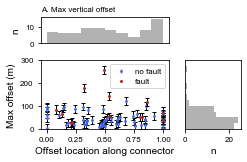

In [15]:
## maximum vertical offset
## separate dataset: fault/no fault
ind_f  = np.where(v_offs_max[:,7] == 1) # entries with fault
ind_nf = np.where(v_offs_max[:,7] == 0) # entries without fault

y_error_f  = [v_offs_max[ind_f,2][0],v_offs_max[ind_f,3][0]]   # error faults
y_error_nf = [v_offs_max[ind_nf,2][0],v_offs_max[ind_nf,3][0]] # error no faults

m = ['d', '.'] # marker
ms = [5, 15] # marker size
colour = ['royalblue', 'firebrick', 'gray'] # marker colour


## figure
fig = plt.figure(figsize=cm2inch(9,6))

scatter_axes = plt.subplot2grid((3, 3), (1, 0), rowspan=2, colspan=2)
x_hist_axes = plt.subplot2grid((3, 3), (0, 0), colspan=2)
y_hist_axes = plt.subplot2grid((3, 3), (1, 2), rowspan=2)

x_hist_axes.set_title('A. Max vertical offset', loc='left')

# plot scatter and error bars of connectors without faults
scatter_axes.scatter(v_offs_max[ind_nf,6],v_offs_max[ind_nf,1], zorder = 1, c=colour[0], marker=m[0], s=ms[0], label='no fault', linestyle = 'None') #red
scatter_axes.errorbar(v_offs_max[ind_nf,6][0], v_offs_max[ind_nf,1][0], yerr=y_error_nf,
            fmt='none', ecolor='k', elinewidth=1, capsize=2, capthick=1, barsabove=False, zorder=0)

# plot scatter and error bars of connectors with faults
scatter_axes.scatter(v_offs_max[ind_f,6],v_offs_max[ind_f,1], zorder = 3, c=colour[1], marker = m[1], s=ms[1], label='fault', linestyle = 'None') #red
scatter_axes.errorbar(v_offs_max[ind_f,6][0], v_offs_max[ind_f,1][0], yerr=y_error_f,
            fmt='none', ecolor='k', elinewidth=1, capsize=2, capthick=1, barsabove=False, zorder=2)

# histograms
x_hist_axes.hist(v_offs_max[:,6], bins=10, range=(0,1), color=colour[2], alpha=0.6)
y_hist_axes.hist(v_offs_max[:,1], bins=range(0, 300, 25), orientation='horizontal', color=colour[2], alpha=0.6)

# set axes, labels, etc.
scatter_axes.set_ylim(0, 300)
y_hist_axes.set_ylim(0, 300)

scatter_axes.set(ylabel='Max offset (m)')
scatter_axes.set(xlabel='Offset location along connector')
x_hist_axes.set(ylabel='n')
y_hist_axes.set(xlabel='n')

x_hist_axes.axes.get_xaxis().set_ticks([])
y_hist_axes.axes.get_yaxis().set_ticks([])

scatter_axes.legend(loc='upper right')

fig.tight_layout()

if save == 1:
    plt.savefig(save_path + 'sill1_max_voffs4ms_err.pdf', format='pdf')

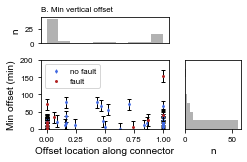

In [16]:
## minimum vertical offset
## separate dataset: fault/no fault
ind_f  = np.where(v_offs_min[:,7] == 1) # entries with fault
ind_nf = np.where(v_offs_min[:,7] == 0) # entries without fault

y_error_f  = [v_offs_min[ind_f,2][0],v_offs_min[ind_f,3][0]]   # error faults
y_error_nf = [v_offs_min[ind_nf,2][0],v_offs_min[ind_nf,3][0]] # error no faults

m = ['d', '.'] # marker
ms = [5, 15] # marker size
colour = ['royalblue', 'firebrick', 'gray'] # marker colour

## figure
fig = plt.figure(figsize=cm2inch(9,6))

scatter_axes = plt.subplot2grid((3, 3), (1, 0), rowspan=2, colspan=2)
x_hist_axes = plt.subplot2grid((3, 3), (0, 0), colspan=2)
y_hist_axes = plt.subplot2grid((3, 3), (1, 2), rowspan=2)

x_hist_axes.set_title('B. Min vertical offset', loc='left')

# plot scatter and error bars of connectors without faults
scatter_axes.scatter(v_offs_min[ind_nf,6],v_offs_min[ind_nf,1], zorder = 1, c=colour[0], marker=m[0], s=ms[0], label='no fault', linestyle = 'None') #red
scatter_axes.errorbar(v_offs_min[ind_nf,6][0], v_offs_min[ind_nf,1][0], yerr=y_error_nf,
            fmt='none', ecolor='k', elinewidth=1, capsize=2, capthick=1, barsabove=False, zorder=0)

# plot scatter and error bars of connectors with faults
scatter_axes.scatter(v_offs_min[ind_f,6],v_offs_min[ind_f,1], zorder = 3, c=colour[1], marker=m[1], s=ms[1], label='fault', linestyle = 'None') #red
scatter_axes.errorbar(v_offs_min[ind_f,6][0], v_offs_min[ind_f,1][0], yerr=y_error_f,
            fmt='none', ecolor='k', elinewidth=1, capsize=2, capthick=1, barsabove=False, zorder=2)

# histograms
x_hist_axes.hist(v_offs_min[:,6], bins=10, range=(0,1), color=colour[2], alpha=0.6)
y_hist_axes.hist(v_offs_min[:,1], bins=range(0, 200, 25), orientation='horizontal', color=colour[2], alpha=0.6)

# set axes limits, labels, etc. 
scatter_axes.set_ylim(0,200)
y_hist_axes.set_ylim(0, 200)

scatter_axes.set(ylabel='Min offset (min)')
scatter_axes.set(xlabel='Offset location along connector')
x_hist_axes.set(ylabel='n')
y_hist_axes.set(xlabel='n')

x_hist_axes.axes.get_xaxis().set_ticks([])
y_hist_axes.axes.get_yaxis().set_ticks([])

scatter_axes.legend(loc='upper left')

fig.tight_layout()

if save == 1:
    plt.savefig(save_path + 'sill1_min_voffs_4ms_err.pdf', format='pdf')